## **Data Preprocessing**


### **!!!!! TODO INTRODUCERE IN DATA PREPROCESSING!!!!**

#### **Loading relational MIMIC3 tables**

- Importing the files with details of ICU patient episodes. 

In [205]:
import pandas as pd
import matplotlib.pyplot as plt

data_path = "./data_sets/"

df_patients= pd.read_csv(data_path + 'PATIENTS.csv.gz')        
df_admissions = pd.read_csv(data_path + 'ADMISSIONS.csv.gz')           # Item descriptions
df_icustays = pd.read_csv(data_path + 'ICUSTAYS.csv.gz')        # ICU stay times
df_diagnoses = pd.read_csv(data_path + 'DIAGNOSES_ICD.csv.gz', low_memory=False) # Chart 

##### TODO choosing the disease
- Filtering for ICD-9 code 48283, corresponding to bacterial pneumonia.
- High ICU admission rates -> clinically and epidemiologically relevant for LOS modeling.
- 264 rows = 264 hospital admissions found.

In [206]:
# Filter for Pneumonia (ICD-9 = 48283)
df_target = df_diagnoses[df_diagnoses['ICD9_CODE'] == '48283'][['SUBJECT_ID', 'HADM_ID', 'ICD9_CODE']]

print(df_target.shape)

df_target.head()

(264, 3)


,SUBJECT_ID,HADM_ID,ICD9_CODE
38,114,178393,48283
4202,339,112625,48283
5063,285,165312,48283
7541,605,115545,48283
8075,720,171046,48283


#### **Joining tables**

- Joining admissions with the respective patient data

In [207]:
# Merge with admissions to get LOS
df_merged = pd.merge(
    df_target,
    df_admissions[['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME', 'ADMISSION_TYPE']],
    on=['SUBJECT_ID', 'HADM_ID'],
    how='left'
)
print(df_merged.shape)
df_merged.head()

(264, 6)


,SUBJECT_ID,HADM_ID,ICD9_CODE,ADMITTIME,DISCHTIME,ADMISSION_TYPE
0,114,178393,48283,2146-08-29 01:18:00,2146-09-03 16:06:00,ELECTIVE
1,339,112625,48283,2187-04-20 23:10:00,2187-06-19 13:20:00,EMERGENCY
2,285,165312,48283,2152-09-21 22:47:00,2152-10-20 15:19:00,EMERGENCY
3,605,115545,48283,2197-11-09 12:59:00,2197-11-26 09:36:00,EMERGENCY
4,720,171046,48283,2160-02-15 21:44:00,2160-04-07 13:05:00,EMERGENCY


- Joining table with ICU stays
- Appending relevant patient demographics that influence the prediction

In [208]:
# Merge with ICU stays (if any)
df_merged = pd.merge(
    df_merged,
    df_icustays[['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'INTIME', 'OUTTIME', 'LOS']],
    on=['SUBJECT_ID', 'HADM_ID'],
    how='left'

)

# Add patient demographics (optional)
df_merged = pd.merge(
    df_merged,
    df_patients[['SUBJECT_ID', 'GENDER', 'DOB']],
    on='SUBJECT_ID',
    how='left'
)

df_merged.isnull().sum()


SUBJECT_ID        0
HADM_ID           0
ICD9_CODE         0
ADMITTIME         0
DISCHTIME         0
ADMISSION_TYPE    0
ICUSTAY_ID        0
INTIME            0
OUTTIME           0
LOS               0
GENDER            0
DOB               0
dtype: int64

#### **Feature Derivation and Data Filtering**

- Age is estimated using admission and birth year due to incomplete date precision in MIMIC-III.
- HIPAA constraints on patients ≥89 are mitigated by recoding to 91.
- Short stays (<1 day) and extreme LOS outliers are excluded to reduce heteroscedasticity and improve model generalizability.

In [209]:
df_merged['ADMITTIME'] = pd.to_datetime(df_merged['ADMITTIME'])
df_merged['DOB'] = pd.to_datetime(df_merged['DOB'])

# Subtract the years
df_merged['age'] = df_merged['ADMITTIME'].dt.year - df_merged['DOB'].dt.year
df_merged.loc[df_merged['age'] > 89, 'age'] = 91  # Handle MIMIC-III's >89 group

df_merged = df_merged[df_merged['LOS'] > 1]

df_merged = df_merged.drop(df_merged['LOS'].idxmax())
df_merged = df_merged.drop(df_merged['LOS'].idxmax())
    

df_merged.head()

,SUBJECT_ID,HADM_ID,ICD9_CODE,ADMITTIME,DISCHTIME,ADMISSION_TYPE,ICUSTAY_ID,INTIME,OUTTIME,LOS,GENDER,DOB,age
0,114,178393,48283,2146-08-29 01:18:00,2146-09-03 16:06:00,ELECTIVE,258626,2146-08-29 17:59:00,2146-08-31 13:30:00,1.8132,M,2098-05-09,48
1,339,112625,48283,2187-04-20 23:10:00,2187-06-19 13:20:00,EMERGENCY,221278,2187-04-20 23:10:50,2187-05-22 16:01:27,31.7018,F,2120-07-17,67
2,285,165312,48283,2152-09-21 22:47:00,2152-10-20 15:19:00,EMERGENCY,238023,2152-09-21 22:48:50,2152-10-20 15:19:31,28.6880,M,2107-05-16,45
3,605,115545,48283,2197-11-09 12:59:00,2197-11-26 09:36:00,EMERGENCY,248569,2197-11-09 13:00:45,2197-11-26 09:38:48,16.8598,F,1895-04-05,91
4,720,171046,48283,2160-02-15 21:44:00,2160-04-07 13:05:00,EMERGENCY,261862,2160-02-15 21:45:04,2160-04-04 19:57:31,48.9253,F,2108-08-25,52


#### **Exploratory Cohort Profiling**

- To examine the distributional extremes of ICU length of stay (LOS), the dataset was sorted in both ascending and descending order.
- Sorting to easily choose 3 patients for closely examining and charting.

In [210]:
df_ascending = df_merged.sort_values('LOS', ascending=True)
print("Top 5 Shortest LOS:")
print(df_ascending[['SUBJECT_ID', 'HADM_ID','ICUSTAY_ID', 'LOS', 'INTIME', 'OUTTIME', 'age']].head())

Top 5 Shortest LOS:
     SUBJECT_ID  HADM_ID  ICUSTAY_ID     LOS               INTIME  \
287       87980   110615      243965  1.1159  2142-05-02 15:03:18   
291       94937   162005      280084  1.1432  2107-01-18 11:11:21   
244       63941   126602      270748  1.1496  2196-04-23 14:49:48   
14         3078   147024      272986  1.1541  2175-12-09 15:03:51   
29         5062   123244      250261  1.2110  2100-12-10 12:50:48   

                 OUTTIME  age  
287  2142-05-03 17:50:10   66  
291  2107-01-19 14:37:37   68  
244  2196-04-24 18:25:15   75  
14   2175-12-10 18:45:49   47  
29   2100-12-11 17:54:42   71  


In [211]:
df_descending = df_merged.sort_values('LOS', ascending=False)
print("\nTop 5 Longest LOS:")
print(df_descending[['SUBJECT_ID', 'HADM_ID','ICUSTAY_ID', 'LOS', 'age']].head())


Top 5 Longest LOS:
     SUBJECT_ID  HADM_ID  ICUSTAY_ID      LOS  age
53         7085   106726      283819  60.7469   42
138       21312   150854      213825  55.6920   76
140       22818   188392      241236  55.6687   73
41         4196   114944      249095  54.8424   80
180       26688   129259      299382  51.0566   58


- ```.shape``` indicating the ICU stays
- ```.describe``` used for inspecting the statistics (mostly LOS and age) 

In [212]:
df_merged.shape

(295, 13)

In [213]:
df_merged.describe().T

,count,mean,min,25%,50%,75%,max,std
SUBJECT_ID,295.0,33410.108475,114.0,11283.5,25541.0,49267.5,99715.0,28729.043193
HADM_ID,295.0,150115.684746,100395.0,124995.5,151960.0,174117.5,199845.0,27742.232113
ADMITTIME,295,2150-08-11 23:14:07.525424128,2100-11-30 02:51:00,2124-03-16 11:56:00,2150-04-21 07:15:00,2174-09-16 00:36:00,2207-12-13 20:56:00,NaN
ICUSTAY_ID,295.0,252478.494915,200387.0,231240.5,253774.0,275776.0,299728.0,28280.572249
LOS,295.0,15.485045,1.1159,5.09495,12.464,21.72955,60.7469,12.665445
DOB,295,2079-08-14 19:16:52.881355776,1805-12-07 00:00:00,2056-06-22 00:00:00,2088-03-22 00:00:00,2110-03-24 00:00:00,2173-02-23 00:00:00,NaN
age,295.0,65.220339,19.0,57.0,68.0,77.0,91.0,15.949397


#### **Outcome Transformation**

- Log-transformation of LOS stabilizes variance and addresses right-skew 

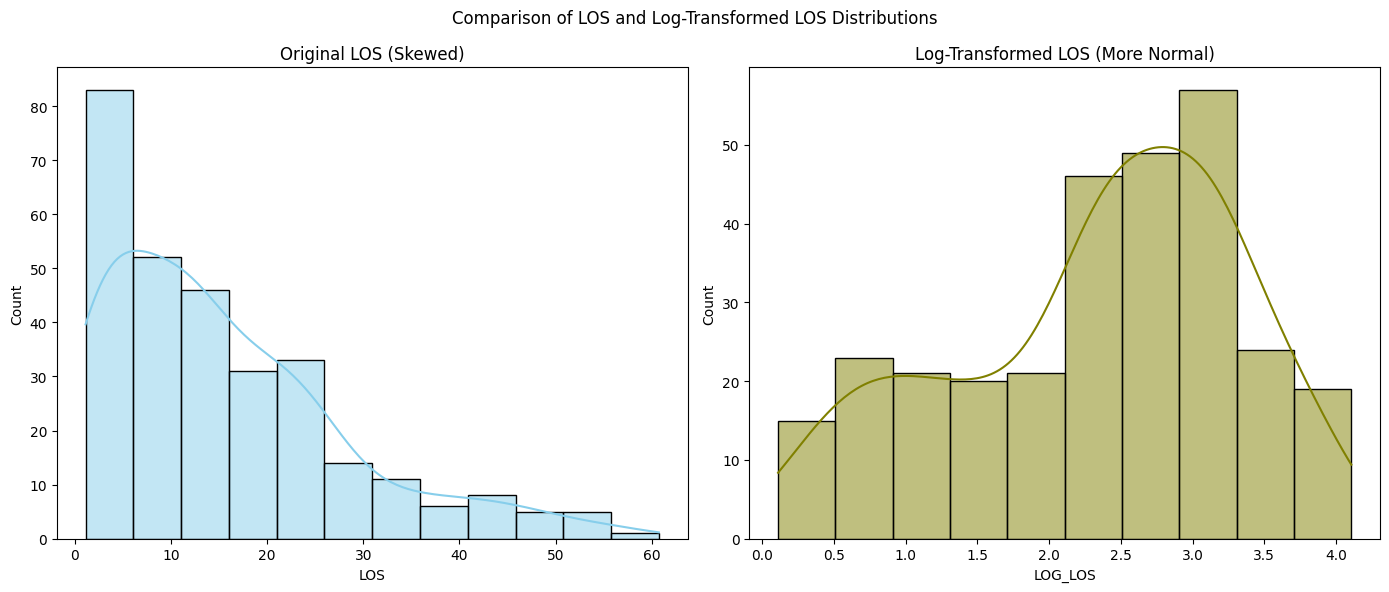

In [214]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df_merged['LOG_LOS'] = np.log(df_merged['LOS'])

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Comparison of LOS and Log-Transformed LOS Distributions')

sns.histplot(df_merged['LOS'], kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Original LOS (Skewed)')

sns.histplot(df_merged['LOG_LOS'], kde=True, ax=axes[1], color='olive')
axes[1].set_title('Log-Transformed LOS (More Normal)')

plt.tight_layout()
plt.show()

- Distribution closer to Gaussian distribution, enabling the use of a wider range of models.

#### **Temporal Framing of ICU Episodes**

Three representative ICU stays were manually selected for a 24-hour observation window.  

In [215]:
selected_small_id = 220271
selected_mean_id =  284345
selected_big_id = 200375

icu_info = df_icustays[df_icustays['ICUSTAY_ID'] == selected_big_id]
icu_info

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,DBSOURCE,FIRST_CAREUNIT,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,INTIME,OUTTIME,LOS
22486,25628,20190,119413,200375,carevue,CCU,CSRU,57,14,2138-10-15 23:22:54,2138-11-11 12:05:15,26.5294


In [216]:
starttime = pd.to_datetime(icu_info['INTIME'].iloc[0])
endtime = starttime + pd.Timedelta(hours=24)

starttime, endtime

(Timestamp('2138-10-15 23:22:54'), Timestamp('2138-10-16 23:22:54'))

#### **Chart Data Integration and Availability Assessment**

Re-validating the merged dataset post-filtering:

In [217]:
print(df_merged.shape)
df_merged.head()

(295, 14)


,SUBJECT_ID,HADM_ID,ICD9_CODE,ADMITTIME,DISCHTIME,ADMISSION_TYPE,ICUSTAY_ID,INTIME,OUTTIME,LOS,GENDER,DOB,age,LOG_LOS
0,114,178393,48283,2146-08-29 01:18:00,2146-09-03 16:06:00,ELECTIVE,258626,2146-08-29 17:59:00,2146-08-31 13:30:00,1.8132,M,2098-05-09,48,0.595093
1,339,112625,48283,2187-04-20 23:10:00,2187-06-19 13:20:00,EMERGENCY,221278,2187-04-20 23:10:50,2187-05-22 16:01:27,31.7018,F,2120-07-17,67,3.456373
2,285,165312,48283,2152-09-21 22:47:00,2152-10-20 15:19:00,EMERGENCY,238023,2152-09-21 22:48:50,2152-10-20 15:19:31,28.6880,M,2107-05-16,45,3.356479
3,605,115545,48283,2197-11-09 12:59:00,2197-11-26 09:36:00,EMERGENCY,248569,2197-11-09 13:00:45,2197-11-26 09:38:48,16.8598,F,1895-04-05,91,2.824932
4,720,171046,48283,2160-02-15 21:44:00,2160-04-07 13:05:00,EMERGENCY,261862,2160-02-15 21:45:04,2160-04-04 19:57:31,48.9253,F,2108-08-25,52,3.890295


- An SQL query is executed to filter only the chartevents of the admissions with the pneumonia diagnostic into 'pneumonia.csv' for faster and easier access
- The filtered subset of the CHARTEVENTS table—specific to the pneumonia cohort is loaded. 

In [218]:
df_chart_events =  pd.read_csv(data_path + 'd_pneumonia.csv', low_memory=False) 
 
print(df_chart_events.shape)      
df_chart_events.head()

(986962, 15)


,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ITEMID,CHARTTIME,STORETIME,CGID,VALUE,VALUENUM,VALUEUOM,WARNING,ERROR,RESULTSTATUS,STOPPED
0,170754,1709,127294,207018,220052,2118-01-04 12:15:00,2118-01-04 14:22:00,19783.0,124.0,124.0,mmHg,0.0,0.0,NaN,NaN
1,170755,1709,127294,207018,220210,2118-01-04 12:15:00,2118-01-04 14:22:00,19783.0,30.0,30.0,insp/min,0.0,0.0,NaN,NaN
2,170756,1709,127294,207018,220277,2118-01-04 12:15:00,2118-01-04 14:22:00,19783.0,96.0,96.0,%,0.0,0.0,NaN,NaN
3,170757,1709,127294,207018,220179,2118-01-04 12:20:00,2118-01-04 14:22:00,19783.0,148.0,148.0,mmHg,0.0,0.0,NaN,NaN
4,170758,1709,127294,207018,220180,2118-01-04 12:20:00,2118-01-04 14:22:00,19783.0,69.0,69.0,mmHg,0.0,0.0,NaN,NaN


- Joining with chart events measurements. 
- Stratification of patients into those with vs. without structured chart data.

In [219]:
# 1. Merge df_merged with CHARTEVENTS (left join to preserve all ICU stays)
df_merged_with_chartevents = pd.merge(
    df_merged[['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID','INTIME']],  # Key columns
    df_chart_events[['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'ITEMID', 'VALUENUM','CHARTTIME','VALUEUOM']].drop_duplicates(),
    on=['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID'],
    how='left',
    indicator=True  # Adds a column '_merge' to show match status
)

# 2. Identify ICU stays with/without CHARTEVENTS
has_chartevents = df_merged_with_chartevents['_merge'] == 'both'
no_chartevents = df_merged_with_chartevents['_merge'] == 'left_only'

# 3. Get the lists of ICUSTAY_IDs
icu_with_data = df_merged_with_chartevents[has_chartevents]['ICUSTAY_ID'].unique()
icu_without_data = df_merged_with_chartevents[no_chartevents]['ICUSTAY_ID'].unique()

print(f"ICU stays WITH CHARTEVENTS data: {len(icu_with_data)}")
print(f"ICU stays WITHOUT CHARTEVENTS data: {len(icu_without_data)}")

df_merged_with_chartevents.head()

ICU stays WITH CHARTEVENTS data: 140
ICU stays WITHOUT CHARTEVENTS data: 155


,SUBJECT_ID,HADM_ID,ICUSTAY_ID,INTIME,ITEMID,VALUENUM,CHARTTIME,VALUEUOM,_merge
0,114,178393,258626,2146-08-29 17:59:00,211.0,72.0,2146-08-30 10:00:00,BPM,both
1,114,178393,258626,2146-08-29 17:59:00,581.0,102.0,2146-08-30 10:00:00,kg,both
2,114,178393,258626,2146-08-29 17:59:00,618.0,20.0,2146-08-30 10:00:00,BPM,both
3,114,178393,258626,2146-08-29 17:59:00,646.0,98.0,2146-08-30 10:00:00,%,both
4,114,178393,258626,2146-08-29 17:59:00,676.0,38.0,2146-08-30 10:00:00,Deg. C,both


- We can only use the ICU stays with chartevents (140), filtering out the rest